In [7]:
# for data managaement
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta

# for charting
import plotly
import plotly.graph_objects as go

In [8]:

data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv',usecols = list(range(0,10)))

continents = pd.read_csv('Assets/continents.csv')

# make datetime
data['dateRep'] = pd.to_datetime(data['dateRep'], dayfirst=True)

#sort values by country and date
data.sort_values(by=['countriesAndTerritories','dateRep'], ascending = True, inplace = True)

#reindex the data now its sorted to prevent errors when creating aggregates
data = data.reindex()

# create a global aggregate figure for cases and deaths
world = data[['dateRep','cases','deaths','popData2018']].groupby(by='dateRep').sum()

world['day'] = world.index.day
world['month'] = world.index.month
world['year'] = world.index.year
world['dateRep'] = world.index
world['countriesAndTerritories'] = 'World'
world['geoId'] = 'WD'
world['countryterritoryCode']  = 'WLD'
df = pd.concat([data, world], ignore_index=True)

# Create a continents var

data = pd.merge(data, continents[['Continent_Name','Three_Letter_Country_Code']].drop_duplicates('Three_Letter_Country_Code'), how='left', left_on='countryterritoryCode', right_on='Three_Letter_Country_Code')
#create cumulative sum of deaths and cases by country and death rate
data['total_cases'] = data.groupby(by='countriesAndTerritories')['cases'].cumsum()
data['total_deaths'] = data.groupby(by='countriesAndTerritories')['deaths'].cumsum()

data['death_rate'] = data['total_deaths']/data['total_cases']*100




In [16]:
data = data.replace({'Democratic_Republic_of_the_Congo':'D.R.C'}, regex=True)

In [15]:
data['countriesAndTerritories'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua_and_Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius and Saba', 'Bosnia_and_Herzegovina',
       'Botswana', 'Brazil', 'British_Virgin_Islands',
       'Brunei_Darussalam', 'Bulgaria', 'Burkina_Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape_Verde',
       'Cases_on_an_international_conveyance_Japan', 'Cayman_Islands',
       'Central_African_Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo', 'Costa_Rica', 'Cote_dIvoire', 'Croatia', 'Cuba',
       'Curaçao', 'Cyprus', 'Czechia', 'Democratic_Republic_of_the_Congo',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican_Republic', 'Ecuador',
       'Egypt', 'El_Salvador', 'Equatorial_Guinea', 'Eritrea', 'Estonia',


In [17]:
# series in the "data" dataframe which is a string of dates
data['date'] = [pd.to_datetime(str(x)).strftime('%d %b') for x in data['dateRep']]

# create a list of date strings
days = data['dateRep'][data['dateRep'] > pd.to_datetime('15-02-2020')].sort_values(ascending=True).unique()
days = [pd.to_datetime(str(x)).strftime('%d %b') for x in days]

num_ = 204
threshold = 100


C:\Users\lundr\Miniconda3\envs\dsj\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lundr\Miniconda3\envs\dsj\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



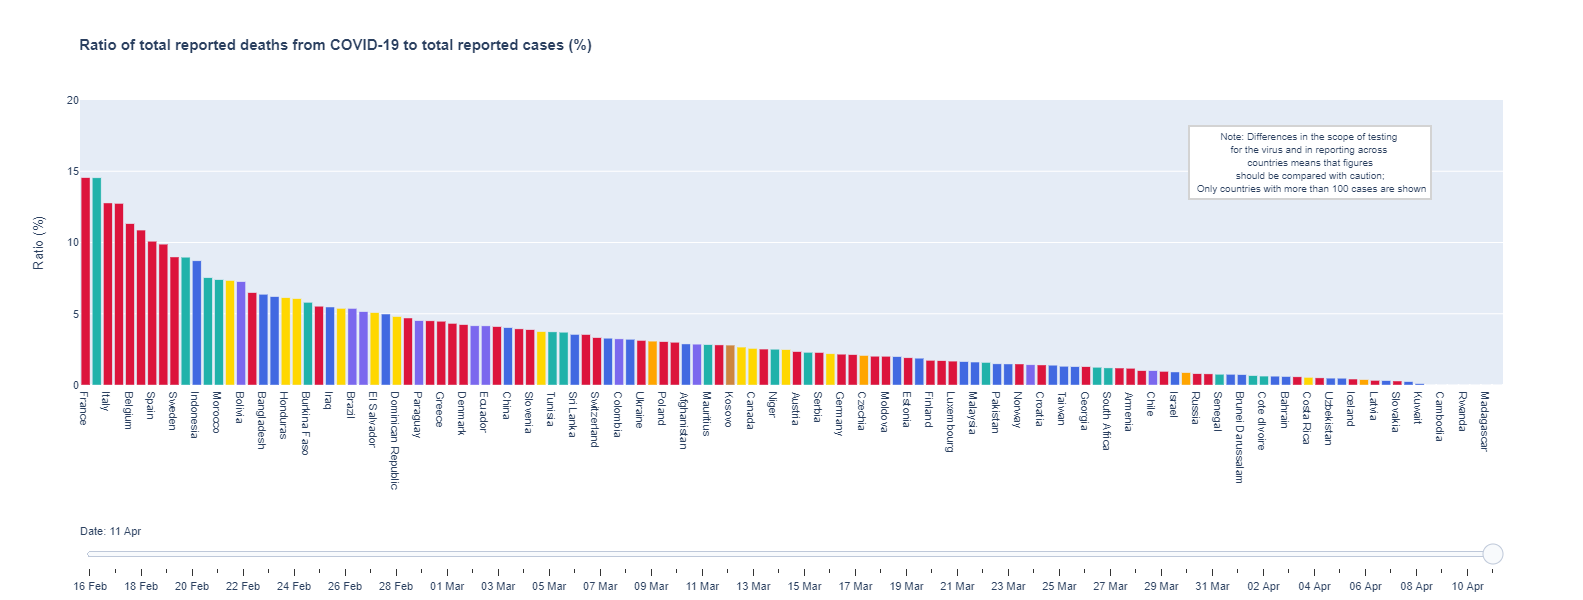

In [18]:
##### data


colours = {'Asia':"royalblue", 'Europe':"crimson", 'Africa':"lightseagreen", 'Oceania':"orange", 'North America':"gold",
       'South America':'mediumslateblue', "nan":"peru"}

# choose the first date in the 'days' list as your data
day = days[-1]

#subset the data by date
chart_data = chart_data = data.loc[(data['date'] == day) & (data['total_cases'] > threshold)].sort_values(by = 'death_rate', ascending = False)

# select only the first num_ countries in the new dataframe
chart_data_2 = chart_data[0:num_]

# create a colour variable for the new dataframe, assigning each country a colour according to the colour dictionary
chart_data_2['colour'] = [colours[str(x)] for x in chart_data_2['Continent_Name']]

# define the chart
data_ = [go.Bar(x = [' '.join(x.split('_')) for x in chart_data_2['countriesAndTerritories']],
                y=chart_data_2['death_rate'],
                name = '',
                 text = chart_data_2['countriesAndTerritories'].tolist(),
                customdata=chart_data_2['total_cases'],
#                 textposition='auto',
                marker=dict(color=chart_data_2['colour'].tolist()),
               hovertemplate = "<br><b>%{text}</b><br> Death Rate (%): %{y:0.1f}<br>Total Cases: %{customdata:,}<extra></extra>")]


### layout
    
layout = go.Layout(
    height = 600,
    width = 900,
    title = "<b>Ratio of total reported deaths from COVID-19 to total reported cases (%)</b>",
     font=dict(
               family="Arial",
                size=11

            ))

### frames 

# define lists to capture frames and steps in a loop
frames = []
steps = []

# loop through days making a new frame and a new step each time
for day in days:
    # create data subset, based on date, and threshold, sort values, take the first num_ countries then assign colours
    chart_data = chart_data = data.loc[(data['date'] == day) & (data['total_cases'] > threshold)].sort_values(by = 'death_rate', ascending = False)
    chart_data_2 = chart_data[0:num_]
    chart_data_2['colour'] = [colours[str(x)] for x in chart_data_2['Continent_Name']]
    
    # create chart 
    frame = go.Frame(name = day, 
                     data =[ go.Bar(x = [' '.join(x.split('_')) for x in chart_data_2['countriesAndTerritories']],
                                                y=chart_data_2['death_rate'],
                                                name = '',
                                                 text = chart_data_2['countriesAndTerritories'].tolist(),
                                            customdata=chart_data_2['total_deaths'],
#                                                 textposition='auto',
                                                marker=dict(color=chart_data_2['colour'].tolist()),
                                                hovertemplate = "<br><b>%{text}</b><br> Death Rate (%): %{y:0.1f}<br>Total Cases: %{customdata:,}<extra></extra>")]
                                               )
    # add to chart list    
    frames.append(frame)  
    
    # create steps
    step = dict(
        method="animate",
        args=[
        [day],
        {"frame": {"duration": 100,
                   "redraw": True},
         "mode": "immediate",
         "transition": {"duration": 100,
                        "easing": "quad-in"}}
    ],
        label = day,
        
    )
    
    # append step to step list
    steps.append(step)



# Create and add aslider
sliders = [dict(   
    y = -0.3,
    active=len(days)-1,
    currentvalue={"prefix": "Date: ",
                  "visible" :True},
    transition = {"duration": 300},
    pad={"t": 50},
    steps=steps
)]

# append slider information to layout.
layout['sliders'] = sliders

#add a footnote
footnote = dict(xref='paper', 
                xanchor='right',
                text = "Note: Differences in the scope of testing <BR>for the virus and in reporting across <BR> countries means that figures <BR> should be compared with caution; <BR> Only countries with more than 100 cases are shown",
                x=0.95, 
                yanchor='bottom',
                yshift = -100,
                xshift = 0,
                showarrow=False,
                 font=dict(
             #   family="Ariel",
                size=10

            ),
                bgcolor="#ffffff",
                bordercolor="#D3D3D3",
                borderwidth=2,
                borderpad=4,
                y=20)

layout['annotations'] = [footnote]

# make the chart
fig = go.Figure(data_,layout,frames)

#fix the axes
fig.layout.yaxis.update(range=[0,
                              20],title = 'Ratio (%)')



# show the figure
fig.show()

